In [1]:
import numpy as np
import numpy.random as rand

from tensorforce.environments import Environment
from tensorforce.agents import DQNAgent
from tensorforce.execution import Runner

This example runs on python 2.7 and most notably tensorforce 0.3.2-5-g8036406
This example is derived hevily from tensorforce/examples/quickstart.py

We start by setting up the environement. Again we heavily used the examples from tensorforce

In [2]:
class MySimpleEnv(Environment):


    def __init__(self, hshift_range=[-2,2], start_pos_range=[-2,2], step_size=0.1):

        self.hshift_range = hshift_range
        self.start_pos_range = start_pos_range
        self.step_size = step_size

        self.pos_init = rand.uniform(*self.start_pos_range)
        self.pos = self.pos_init
        self.hshift = rand.uniform(*self.hshift_range)
        print '**** initialization done'

        while -(self.pos-self.hshift)**2 +10 > 8.0 :
            self.pos_init = rand.uniform(*self.start_pos_range)
            self.pos = self.pos_init

        
    def get_env(self):
        return self.pos, self.hshift
        
    def __str__(self):
        return 'my stuff __str__'

    def reset(self):
        print '***** reset of env called'
        self.pos_init = rand.uniform(*self.start_pos_range)
        self.pos = self.pos_init



        self.hshift = rand.uniform(*self.hshift_range)
        self.actions_previous = 0


        # Here I make sure the initial position is far from the top
        while( -(self.pos-self.hshift)**2 +10 > 8.0 and
               np.abs(self.pos-self.hshift)<15) :
        
            self.pos_init = rand.uniform(*self.start_pos_range)
            self.pos = self.pos_init


        print '*****  state is reset', self.pos
        target = -(self.pos-self.hshift)**2 +10
        self.target_prev = target
        self.target_init = target
        return np.array((self.pos, target))

    def execute(self, actions):
        # action mooves up or down along x by step_size -> +1 or -1

        actions_previous = self.actions_previous
        self.actions_previous = actions
        self.pos_prev = self.pos
        if( actions==1):
            self.pos += self.step_size
        else:
            self.pos -= self.step_size
        
        
        target = -(self.pos-self.hshift)**2 +10
        if(target < -200) :
            print 'killing, reward too bad'
            terminal = True
            reward = -1
        elif( target > 9.8 ) :
            print 'killing, reward good engouht', np.abs(self.pos_init - self.hshift)
            terminal = True
            reward = 10
        elif( target > self.target_init and target > self.target_prev):
            terminal = False
            reward = 0.01
        else :
            terminal = False
            reward = 0

        self.target_prev = target
        state = np.array((self.pos, target))
        return state, terminal, reward
    


    @property
    def states(self):
        print '******* states got picked'
        return {'shape': (2,), 'type': 'float'}

    @property
    def actions(self):
        print '******* actions got picked'
        return {'type': 'int', 'num_actions': 2}



To be noted is that the states and actions methods provide to tensorforce the way to interact with the environement

Here I create my environement

In [3]:
env = MySimpleEnv()

**** initialization done


Then I setup some things but it's basically copy-paste from tensorforce examples

In [4]:
network_spec = [
    dict(type='dense', size=32, activation='tanh'),
    dict(type='dense', size=32, activation='tanh')
]

agent = DQNAgent(
    states_spec=env.states,
    actions_spec=env.actions,
    network_spec=network_spec,
    batch_size=8,
    first_update=10,
    target_sync_frequency=10
)

******* states got picked
******* actions got picked


The a runner is created. It is charged to handle the interactions between the agent and the environement

In [5]:
runner = Runner(agent=agent, environment=env)

a small function that will be called after every episode to give a summary of what happened

In [6]:
def episode_finished(r):
    print("Finished episode {ep} after {ts} timesteps (reward: {reward})".format(ep=r.episode, ts=r.episode_timestep,
                                                                                 reward=r.episode_rewards[-1]))
    return True

Now we can start the learning

In [7]:
runner.run(episodes=50, max_episode_timesteps=200, episode_finished=episode_finished)

***** reset of env called
*****  state is reset 1.3704711474
killing, reward good engouht 1.87183069409
Finished episode 1 after 153 timesteps (reward: 10.61)
***** reset of env called
*****  state is reset -1.73128953122
killing, reward good engouht 2.19156855071
Finished episode 2 after 70 timesteps (reward: 10.37)
***** reset of env called
*****  state is reset -1.82686329948
Finished episode 3 after 201 timesteps (reward: 1.05)
***** reset of env called
*****  state is reset 0.587868435835
Finished episode 4 after 201 timesteps (reward: 0.3)
***** reset of env called
*****  state is reset -1.8805629577
Finished episode 5 after 201 timesteps (reward: 0.79)
***** reset of env called
*****  state is reset 0.0193700882911
killing, reward good engouht 1.68276951164
Finished episode 6 after 25 timesteps (reward: 10.16)
***** reset of env called
*****  state is reset 1.90930736126
Finished episode 7 after 201 timesteps (reward: 0.78)
***** reset of env called
*****  state is reset -1.2441

In [8]:
import matplotlib.pyplot as plt
plt.plot(range(len(runner.episode_rewards)), runner.episode_rewards, 'bx')

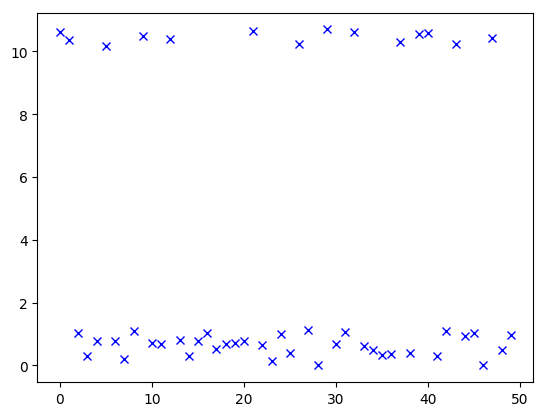

In [9]:
plt.show()